In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

In [2]:
# Load in cleaned dataset of restaurant reviews
reviews = pickle.load( open( "restaurant_reviews_cleaned.pkl", "rb" ) )

In [3]:
reviews

,stars,text,good_bad,language,is_open,length
0,5,love deagans really atmosphere cozy festive sh...,Good,en,1.0,248
1,1,dismal lukewarm defrostedtasting texmex glop m...,Bad,en,0.0,285
2,4,oh happy day finally canes near casa yes other...,Good,en,1.0,501
3,5,definitely favorite fast food sub shop ingredi...,Good,en,1.0,355
4,5,really good place simple decor amazing food gr...,Good,en,1.0,246
...,...,...,...,...,...,...
5026161,5,confections cash casinos welcome las vegas fin...,Good,en,0.0,1014
5026162,3,solid american food southern comfort flare war...,Neutral,en,1.0,912
5026163,5,im honestly sure never place im definitely goi...,Good,en,1.0,685
5026164,3,food decent say service took way long order ev...,Neutral,en,1.0,214


In [4]:
# Creating a dataframe for performance metrics
d = {'Accuracy': [], 'Recall': [], 'F1-Score': []}
metrics = pd.DataFrame(data=d)
metrics.index.name = 'Model'
metrics

,Accuracy,Recall,F1-Score
Model,,,


# Naive Bayes Classifier

In [5]:
# Creating feature array and target array
def make_xy(reviews, vectorizer=None, min_df=0):    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df)
    X = vectorizer.fit_transform(reviews.text)
    X = X.tocsc()  # some versions of sklearn return COO format
    
    # Creating numeric target
    target_dict = {'Bad':0, 'Neutral':1, 'Good': 2}
    y = reviews.good_bad.map(target_dict)
    
    return X, y

# Timing start
start_time = timeit.default_timer()

# min_df tuned to 20 based on analysis below
min_df=20
vectorizer = CountVectorizer(min_df=20)
X, y = make_xy(reviews, vectorizer)

# Elapsed time calculation
elapsed = timeit.default_timer() - start_time

print('For min_df = ' + str(min_df))
print('Elapsed Time (minutes): ' + str(elapsed/60))


For min_df = 20
Elapsed Time (minutes): 5.5871856343


In [8]:
pickle.dump( X, open( "X_vectorized_min_df_20.pickle", "wb" ) )

In [9]:
pickle.dump(y, open( "y_vectorized_min_df_20.pickle", "wb" ) )

In [6]:
# properties of reviews
print('Reviews is a ' + str(type(reviews.text)))
print('... with ' + str(len(reviews.text)) + ' elements <<< this is the expected number of reviews')
print('... and here are few elements of it: ')
reviews.text.head()

Reviews is a <class 'pandas.core.series.Series'>
... with 5026166 elements <<< this is the expected number of reviews
... and here are few elements of it: 


0    love deagans really atmosphere cozy festive sh...
1    dismal lukewarm defrostedtasting texmex glop m...
2    oh happy day finally canes near casa yes other...
3    definitely favorite fast food sub shop ingredi...
4    really good place simple decor amazing food gr...
Name: text, dtype: object

In [6]:
# Investigating shape
X_n_rows, X_n_cols = X.shape[0], X.shape[1]
print('X has ' + str(X_n_rows) + ' rows, and ' + str(X_n_cols) + ' columns')

X has 5026166 rows, and 74158 columns


In [8]:
1-275585/1251938

0.7798732844597736

In [9]:
1-180411/1251938

0.8558946209796332

In [7]:
1-111861/1251938

0.9106497286606845

In [6]:
1-74158/1251938

0.9407654372660627

# Min_df = 10 trims to 111k words. 

The Vectorized Matrix has the correct number of reviews and 111861 words for a 91% reduction in word list

# Min_df = 20 trims to 74k words. 

The Vectorized Matrix has the correct number of reviews and 74158 words for a 94% reduction in word list

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB()
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.808195 and the test accuracy is 0.806031
There are 5026166 reviews and 74158 features extracted by the vectorizer


In [14]:
# Creating word frequencies
word_frequencies = np.array([X[:,i].count_nonzero() for i in range(X_n_cols)])

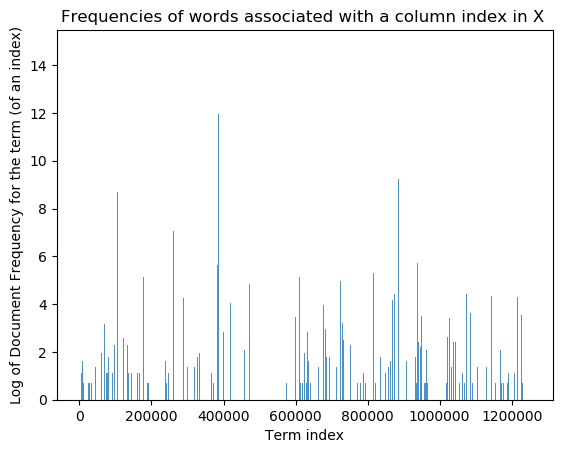

In [15]:
### Very Time intensive for full dataset. On the order of 8-20 hours

import math
plt.rcdefaults()
word_frequencies_log = [math.log(x) for x in word_frequencies]
x_values = [i for i in range(X_n_cols)]
plt.bar(x_values, word_frequencies_log, align='center', alpha=0.8)
plt.ylabel('Log of Document Frequency for the term (of an index)')
plt.xlabel('Term index')
plt.title('Frequencies of words associated with a column index in X ')
plt.show()

In [16]:
max_doc_freq = np.max(word_frequencies)
x_values = range(max_doc_freq)

In [17]:
y_values  = np.array([np.sum(word_frequencies <= i) for i in range(max_doc_freq)])/X_n_cols

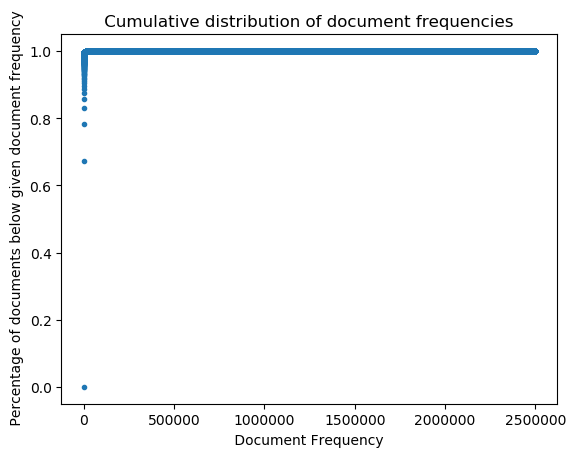

In [18]:
plt.plot(x_values, y_values, marker = '.',linestyle = 'none')
plt.ylabel(' Percentage of documents below given document frequency')
plt.xlabel(' Document Frequency ')
plt.title(' Cumulative distribution of document frequencies ')
plt.show()

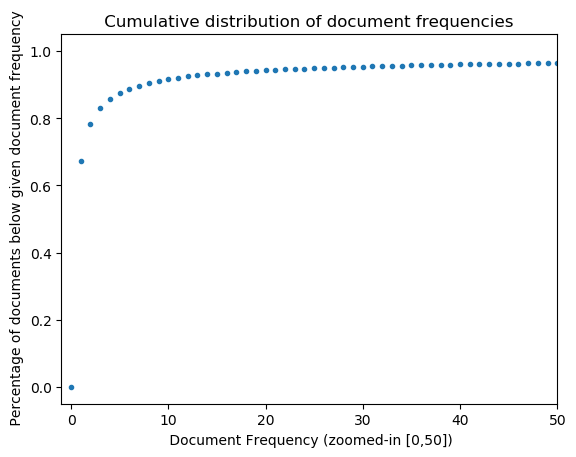

In [20]:
plt.plot(x_values, y_values, marker = '.',linestyle = 'none')
plt.xlim([-1,50])
plt.ylabel(' Percentage of documents below given document frequency')
plt.xlabel(' Document Frequency (zoomed-in [0,50])')
plt.title(' Cumulative distribution of document frequencies ')
plt.show()

# Document Frequency Tuning

min_df has been selected at 20. This removes 94% of the words present, but at a document count of larger than 5 million, words that do not appear in 20 documents (0.0004%) of documents are likely not words we care about. The word list still has words that are nonsensical so I would be open to a larger Min_df for consideration. 

In [8]:
# This can be used to see words in vectorizer
words = np.array(vectorizer.get_feature_names())
words[-1]

'茶餐廳'

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB()
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

# Predictions for the test/training set
y_pred_test = nBayes.predict(X_test)
y_pred_train = nBayes.predict(X_train)

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.808227 and the test accuracy is 0.806120
There are 5026166 reviews and 74158 features extracted by the vectorizer


In [10]:
print(confusion_matrix(y_test, nBayes.predict(X_test)))

[[160541  43468  12057]
 [ 25723  64972  36329]
 [ 23642  53676 584826]]


In [11]:
print (classification_report(y_test, y_pred_test) )

              precision    recall  f1-score   support

           0       0.76      0.74      0.75    216066
           1       0.40      0.51      0.45    127024
           2       0.92      0.88      0.90    662144

    accuracy                           0.81   1005234
   macro avg       0.70      0.71      0.70   1005234
weighted avg       0.82      0.81      0.81   1005234



In [12]:
# Classification reports
nbayes_report_test = classification_report(y_test, y_pred_test, output_dict = True)
nbayes_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_train['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_train['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Naive Bayes train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_test['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_test['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Naive Bayes test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8234,0.8061,0.8136


# Alpha Tuning

In [17]:
parameters = {'alpha':[1, 5, 10, 15, 20, 25, 30, 35, 40, 45]}
grid_search = GridSearchCV(nBayes, parameters, cv=5)
grid_search.fit(X, y)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [23]:
alphas=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45]
for i in range(len(alphas)):
    print('alpha = ' + str(alphas[i]))
    print('score = ' + str(grid_search.cv_results_['mean_test_score'][i]))

alpha = 1
score = 0.8047792293370334
alpha = 5
score = 0.8066961974594552
alpha = 10
score = 0.8102380621730361
alpha = 15
score = 0.8136581640956546
alpha = 20
score = 0.8164585093289796
alpha = 25
score = 0.8184570505629938
alpha = 30
score = 0.8196812441133062
alpha = 35
score = 0.820258224658716
alpha = 40
score = 0.8203754113970768
alpha = 45
score = 0.8200365845457551


GridSearch_CV returns the best results as alpha=40 for min_df=10

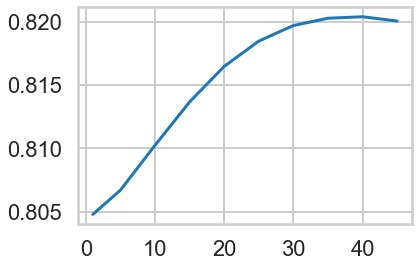

In [24]:
plt.plot(alphas,grid_search.cv_results_['mean_test_score'])

# Alpha = 40

In [13]:
# Train/test split only needed if skipping above code
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB(alpha=40)
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

# Predictions for the test/training set
y_pred_test = nBayes.predict(X_test)
y_pred_train = nBayes.predict(X_train)

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.819406 and the test accuracy is 0.818700
There are 5026166 reviews and 74158 features extracted by the vectorizer


In [14]:
print (classification_report(y_train, y_pred_train ))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76    864264
           1       0.44      0.36      0.40    508093
           2       0.90      0.92      0.91   2648575

    accuracy                           0.82   4020932
   macro avg       0.70      0.69      0.69   4020932
weighted avg       0.81      0.82      0.81   4020932



In [15]:
print (classification_report(y_train, y_pred_train ))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76    864264
           1       0.44      0.36      0.40    508093
           2       0.90      0.92      0.91   2648575

    accuracy                           0.82   4020932
   macro avg       0.70      0.69      0.69   4020932
weighted avg       0.81      0.82      0.81   4020932



In [16]:
# Classification reports
nbayes_report_test = classification_report(y_test, y_pred_test, output_dict = True)
nbayes_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_train['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_train['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['NB alpha 40 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_test['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_test['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['NB alpha 40 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8234,0.8061,0.8136
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8087,0.8187,0.8131


# Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
# Split the data into a training and test set. ONly needed if 
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

logRegression = LogisticRegression(solver = 'lbfgs', multi_class='auto')
# Fit the model on the trainng data.
logRegression.fit(X_train, y_train)

# Print the accuracy from the testing data.
y_pred_test = logRegression.predict(X_test)
y_pred_train = logRegression.predict(X_train)
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Test Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    216066
           1       0.56      0.31      0.40    127024
           2       0.89      0.96      0.93    662144

    accuracy                           0.85   1005234
   macro avg       0.76      0.70      0.72   1005234
weighted avg       0.84      0.85      0.84   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    864264
           1       0.58      0.32      0.41    508093
           2       0.89      0.96      0.93   2648575

    accuracy                           0.86   4020932
   macro avg       0.76      0.71      0.72   4020932
weighted avg       0.84      0.86      0.84   4020932



In [19]:
# Classification reports
logReg_report_test = classification_report(y_test, y_pred_test, output_dict = True)
logReg_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_train['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_train['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_test['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_test['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8234,0.8061,0.8136
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8087,0.8187,0.8131
Logistic Regression train,0.8378,0.8554,0.8410
Logistic Regression test,0.8351,0.8535,0.8387


In [16]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average


In [17]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

# Consider solver = 'saga'
for test_c in Cs:    
    print('C= ' + str(test_c))
    lReg = LogisticRegression(C=test_c, solver='lbfgs', multi_class='auto')
    test_score = cv_score(lReg, X, y)
    print('Score = ' + str(test_score))

C= 0.001


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed 

Score = 0.8433832066425794
C= 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.8516248763311557
C= 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.8516362170476593
C= 10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.851734701651465
C= 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Sp

Score = 0.8517060516210441


C = 0.001
Score = 0.84338

C = 0.1
Score = 0.85162

C = 1
Score = 0.85164

C = 10
Score = 0.85173

C = 100
Score = 0.851706


In [28]:
lReg_cv.best_params_

{'C': 10.0}

In [26]:
# List of C values to cycle
Cs = [0.01, 0.1, 1, 10, 50, 100]
param_grid = {'C' : np.array(Cs)}

lReg = LogisticRegression(solver = 'saga', multi_class='auto')
lReg_cv = GridSearchCV(lReg, param_grid, cv=5, refit = True)
lReg_cv.fit(X,y)
#print("Tuned Logistic Regression Parameters: {}".format(lReg_cv.best_params_)) 
#print("Best score is {}".format(lReg_cv.best_score_))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
sorted(lReg_cv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [23]:
lReg_cv

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 5.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
lReg = LogisticRegression(C=10, solver='lbfgs', multi_class='auto')
lReg.fit(X_train, y_train)

# Print the accuracy from the testing data.
y_pred_test = lReg.predict(X_test)
y_pred_train = lReg.predict(X_train)
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Test Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    216066
           1       0.57      0.31      0.40    127024
           2       0.89      0.96      0.93    662144

    accuracy                           0.85   1005234
   macro avg       0.76      0.70      0.72   1005234
weighted avg       0.84      0.85      0.84   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    864264
           1       0.58      0.31      0.41    508093
           2       0.89      0.96      0.93   2648575

    accuracy                           0.86   4020932
   macro avg       0.76      0.71      0.72   4020932
weighted avg       0.84      0.86      0.84   4020932



In [21]:
# Classification reports
logReg_report_test = classification_report(y_test, y_pred_test, output_dict = True)
logReg_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_train['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_train['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression C=10 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_test['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_test['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression C=10 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8234,0.8061,0.8136
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8087,0.8187,0.8131
Logistic Regression train,0.8378,0.8554,0.8410
Logistic Regression test,0.8351,0.8535,0.8387
Logistic Regression C=10 train,0.8379,0.8556,0.8409
Logistic Regression C=10 test,0.8351,0.8535,0.8385


scipy.sparse.csc.csc_matrix

# Feature Importance - Logistic Regression Coefficients

In [71]:
cols = X.shape[1]
arr = np.empty(shape=cols)
for i in range(cols):
    arr[i] = np.std(X[:, i].toarray())

In [74]:
arr.shape

(74158,)

In [83]:
lReg.coef_[:,0]

array([ 0.03865404,  0.01303197, -0.051686  ])

In [86]:
lReg.coef_[0,:]

array([ 0.03865404,  0.00801527, -0.00293489, ..., -0.00559341,
       -0.00768927, -0.00088573])

In [87]:
print (np.argsort(lReg.coef_[0,:])[-1:])


[50811]


In [112]:
most_influential_indicies_bad_reviews = np.argsort(lReg.coef_[0,:])[-10:]
most_influential_indicies_good_reviews = np.argsort(lReg.coef_[2,:])[-10:]

In [93]:
lReg.coef_[0, np.argsort(lReg.coef_[0,:])[-10:]]

array([0.99936269, 1.00034723, 1.0258608 , 1.03253477, 1.04829904,
       1.05055235, 1.07070902, 1.18775082, 1.41926192, 1.80857813])

In [118]:
most_influential_word_list = []
bad_words = []
good_words = []

print('Influential Bad Words')
print('')
for word_loc in most_influential_indicies_bad_reviews:
    print(list(vectorizer.vocabulary_.keys())[word_loc])
    bad_words.append(list(vectorizer.vocabulary_.keys())[word_loc])
    
print('')
print('Influential Good Words')
print('')
    
for word_loc in most_influential_indicies_good_reviews:
    print(list(vectorizer.vocabulary_.keys())[word_loc])
    good_words.append(list(vectorizer.vocabulary_.keys())[word_loc])


Influential Bad Words

caledonian
940am
stews
recipie
nikki
incensed
ida
tottie
variances
buffs

Influential Good Words

longso
whacking
gogi
aaaa
poboys
preflight
helpfulthe
cleaning
barelythere
moreno


In [102]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=20,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

# Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
X = pickle.load( open( "X_vectorized_min_df_20.pickle", "rb" ) )

In [6]:
y = pickle.load( open( 'y_vectorized_min_df_20.pickle', 'rb' ))

In [7]:
## Only needed if not split above

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [24]:
# Random Forest Model using all processing cores
rForest = RandomForestClassifier(n_estimators=300, max_features='log2', max_depth=20, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300building tree 3 of 300
building tree 4 of 300


building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300building tree 34 of 300

building tree 35 of 300
building tree 36 of 300


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.6s


building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300building tree 51 of 300

building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min


building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300building tree 163 of 300

building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300building tree 178 of 300

building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300building tree 186 of 300

building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300building tree 195 of 300

building tree 196 of 300
building tree 197 of 300
building tree 198 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [25]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   51.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.5min finished


Test Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67    216066
           1       0.30      0.38      0.34    127024
           2       0.83      0.82      0.83    662144

    accuracy                           0.73   1005234
   macro avg       0.61      0.61      0.61   1005234
weighted avg       0.74      0.73      0.73   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.67    864264
           1       0.31      0.39      0.35    508093
           2       0.83      0.83      0.83   2648575

    accuracy                           0.73   4020932
   macro avg       0.62      0.62      0.62   4020932
weighted avg       0.74      0.73      0.74   4020932



In [26]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8255,0.8082,0.8157
Naive Bayes test,0.8234,0.8061,0.8136
NB alpha 40 train,0.8094,0.8194,0.8138
NB alpha 40 test,0.8087,0.8187,0.8131
Logistic Regression train,0.8378,0.8554,0.8410
Logistic Regression test,0.8351,0.8535,0.8387
Logistic Regression C=10 train,0.8379,0.8556,0.8409
Logistic Regression C=10 test,0.8351,0.8535,0.8385
Random Forest train,0.7437,0.7306,0.7361


In [53]:
rForest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=50, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000

building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min


building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000building tree 41 of 1000

building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.1min


building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000
building tree 187 of 1000
building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 25.8min


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 49.0min


building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tre

building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 79.9min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [54]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)

print ('Random Forest -- 1000/50/log2')
print ('')
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 11.3min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 17.0min finished


Test Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71    216066
           1       0.34      0.38      0.36    127024
           2       0.85      0.86      0.85    662144

    accuracy                           0.76   1005234
   macro avg       0.65      0.64      0.64   1005234
weighted avg       0.76      0.76      0.76   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74    864264
           1       0.43      0.44      0.43    508093
           2       0.86      0.88      0.87   2648575

    accuracy                           0.79   4020932
   macro avg       0.69      0.67      0.68   4020932
weighted avg       0.79      0.79      0.79   4020932



In [55]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 1000 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 1000 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8235,0.8061,0.8136
Naive Bayes train,0.8235,0.8061,0.8136
Naive Bayes test,0.8235,0.8061,0.8136
Naive Bayes train,0.8255,0.8082,0.8156
Naive Bayes test,0.8235,0.8061,0.8136
NB alpha 40 train,0.8095,0.8194,0.8139
NB alpha 40 test,0.8082,0.8183,0.8126
Logistic Regression train,0.8095,0.8194,0.8139
Logistic Regression test,0.8082,0.8183,0.8126


In [59]:
rForest = RandomForestClassifier(n_estimators=3000, max_features='log2', max_depth=50, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 3000
building tree 2 of 3000
building tree 3 of 3000building tree 4 of 3000

building tree 5 of 3000
building tree 6 of 3000
building tree 7 of 3000
building tree 8 of 3000
building tree 9 of 3000
building tree 10 of 3000
building tree 11 of 3000
building tree 12 of 3000
building tree 13 of 3000
building tree 14 of 3000
building tree 15 of 3000
building tree 16 of 3000
building tree 17 of 3000
building tree 18 of 3000
building tree 19 of 3000
building tree 20 of 3000
building tree 21 of 3000
building tree 22 of 3000
building tree 23 of 3000
building tree 24 of 3000
building tree 25 of 3000
building tree 26 of 3000
building tree 27 of 3000
building tree 28 of 3000
building tree 29 of 3000
building tree 30 of 3000


KeyboardInterrupt: 

In [ ]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)

print ('Random Forest -- 3000/50/sqrt')
print ('')
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

In [ ]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 5000 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 5000 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

# Coding notes -- reflective thoughts by author

These thoughts are not meant for delivery to customer but could have influence on report writing, personal growth, future analysis, or project continuations. If you want to know how I think it's a fun read I suppose. 



- min_df was interesting since the dataset was so large. Even with min_df=20 there were non-words and other language symbols in the vectorizer. Some analysis of increasing this could be interesting. At 94% of the unique word count removed at min_df=20 I was comfortable leaving it there hoping for low influence on nonsensical/lower frequency tokens.
- The langdetect module used in data cleaning established a language for each review. My assumption for any non-English tokens is that they came from a mixed language review that was predominantly English. I am curious if this or similar packages could be applied to word tokens to assure only the presence of English words.  
- I would love to try tokens of lengths other than word. (Syllables or bi-grams etc.) This may be beyond current scope of project
- Lots of repeating blocks for metrics storage and printing of results. Could be a good use of function but development was far enough along to leave as is. Consider on future projects. 
- Still developing tuning mechanics. Tuning of C in logistic regression model may not have been required, model did not have over-fitting (train/test performance equal). Performance went up 3%. Valid? What are the consequences of tuning when not needed? Is this a successful gain?